# Kmeans
Lập trình Kmeans và các phương pháp tìm K tối ưu

In [1]:
import numpy as np
import pandas as pd
import random as rd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

## Xây dựng Class Kmean bao gồm thuật toán Kmeans và các phương pháp tìm k tối ưu kèm theo.

In [2]:
class KMean():
    def __init__(self, X, max_iters=50, plot_steps=False, init='kmeans++'):
        self.X=X
        self.n,self.d = X.shape
        self.max_iters=max_iters
        self.plot_steps = plot_steps
        self.initial = init

    # nhom kmean
            # lay k tam theo thuat toan Kmeans++ 
    def kmean_plus_plus(self,k):
        centroids_temp = []
        centroids_temp.append(self.X[np.random.choice(self.n)])
        for _ in range(k-1):
            dist= []
            for i in range(self.n):
                data = self.X[i,:]
                temp_dist=[]
                for centroid in centroids_temp:
                    temp_dist.append(np.sum((data - centroid)**2))
                dist.append(np.min(temp_dist))
            centroids_temp.append(self.X[np.argmax(dist),:])
        centroids_temp = np.array(centroids_temp)
        return centroids_temp
    
        # lay k tam nhau nhien
    def kmean_random_centroids(self,k): 
        return self.X[np.random.choice(self.n,k,replace=False)]
        
        # Tinh khoang cach Euclid tu cac diem den cac tam
    def kmean_euclid_dis(self,k):
        distances=np.zeros((self.n,k))
        for i in range(k):
            for j in range(self.d):
                distances[:,i]+=(self.X[:,j]-self.centroids[i,j])**2
        distances=np.sqrt(distances)
        return distances
    
        # lay nhan cua cac diem gan voi cac tam nhat
    def kmean_assign_labels(self,k):
        distances = self.kmean_euclid_dis(k)
        return np.argmin(distances,axis=1)
    
        # tinh lai vi tri cac tam
    def kmean_update_centroids(self,k):
        return np.array([np.mean(self.X[self.labels == i,:],axis=0) for i in range(k)])
    
        # Kiem tra xem 2 tam co trung nhau khong
    def kmean_check_centroids(self, new_centroids):
        return (set([tuple(i) for i in self.centroids])==set([tuple(i) for i in new_centroids])) # Vu Huu Tiep book
    
        # Tao cac Cluster
    def kmean_create_clusters(self):
        self.clusters = [self.X[self.labels == i,:] for i in range(len(self.centroids))]
        return self.clusters
    
        # Plot kmean
    def kmean_plot(self):
        fig, ax = plt.subplots(figsize=(10, 6))
        defi_color=['b','g','r','c','m','y','k','b','g','r','c','m','k','w','b','g','r']
        for i in range(len(self.centroids)):
            ax.scatter(self.clusters[i][:,0],self.clusters[i][:,1],marker='o',color=defi_color[i],alpha=0.7,s=8**2)
            ax.scatter(self.centroids[i,0],self.centroids[i,1],marker='x',color='k',s=12**2)
        plt.show()


        # Chay thuat toan Kmean
    def fit(self,k,plot_steps=True):
        if self.initial.lower() in ['random','rd']:
            self.centroids=self.kmean_random_centroids(k) # Thiet lap tam ngau nhien k tam nhau nhien ban dau
        elif self.initial == 'kmeans++':
            self.centroids=self.kmean_plus_plus(k)
        for _ in range(self.max_iters):
            
            self.labels=self.kmean_assign_labels(k)
                        
            self.clusters=self.kmean_create_clusters()
            if plot_steps and self.plot_steps:
                self.kmean_plot()
                
            new_centroids = self.kmean_update_centroids(k)
            if self.kmean_check_centroids(new_centroids):
                break
            self.centroids=new_centroids

        
        return self.centroids, self.labels
    
    # Nhom Elbow
        # Ham elbow
    def elbow_method(self,num):
        elbow_values = np.zeros(num+1)
        elbow_values[0]=None
        for i in range(1,num+1):
            Centroids,labels=self.fit(i,plot_steps=False)
            for j in range(i):
                elbow_values[i]+=np.sum((self.X[labels==j,:]-Centroids[j])**2)
        self.elbow_values=elbow_values
        return elbow_values
        
        # Hien thi cac gia tri cua elbow method
    def Print_elbow_method(self):
        try:
            for i in range(1,len(self.elbow_values)):
                print('k={}:{}'.format(i,self.elbow_values[i]))
        except :
            print("No values in elbow method yet!")
        
        # Bieu do hoa cac gia tri cua elbow method
    def Show_elbow_method(self):
        try:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(self.elbow_values,'or-')
            ax.set_title('Elbow method')
            ax.set_xlabel('Number of K')
            ax.set_ylabel('Total Within Sum of Square')
            
            plt.show()
        except:
            print("No values in elbow method yet!")
    # Nhom Silhouette
        # Ham silhoutte
    def silhouette_method(self,num,Test=True):
        self.silh_num = num
        Silhoue_mean=np.zeros(num+1)
        Silhoue_mean[0]=Silhoue_mean[1]=None
        Silh_k=[]
        silh_kmean_values=[]
        if Test == True:
            for k in range(2,num+1):
                X_centroids_s, labels_s=self.fit(k, plot_steps=False)
                silh_kmean_values.append([X_centroids_s, labels_s])
                Xlabels=np.concatenate((self.X,labels_s.reshape(-1,1)),axis=1)
                silh=np.zeros((self.n,2))
                for index in range(self.n):
                    #Tách các cụm.
                    #Chọn một giá trị ngẫu nhiên trong cụm và loại bỏ giá trị đã chọn trong cụm đó.
                    Si=self.X[index]
                    Atemp = Xlabels[Xlabels[:,self.d]==Xlabels[index,self.d]]
                    Btemp = Xlabels[Xlabels[:,self.d]!=Xlabels[index,self.d]]
                    if Si in Atemp:
                        Atemp=np.delete(Atemp,np.where(Atemp==Si),axis=0)
                    if Si in Btemp:
                        Btemp=np.delete(Btemp,np.where(Btemp==Si),axis=0)
        
                    if (Atemp.shape[0]-1)==0: # Nếu số lượng phần tử trong cụm = 1 thì trả về 0 để tránh trường hợp chia cho 0.
                        silh[Si]=0
                        continue
                    # Tổng khoảng cách từ i đến các phần tử j trong cụm
                    SumSa=0
                    for j in range(Atemp.shape[1]-1):
                        SumSa+=(Si[j]-Atemp[:,j])**2

                    SumSa=np.sum(np.sqrt(SumSa))

                    SA = (1/(Atemp.shape[0]-1))*SumSa
                    # Tổng khoảng cách từ i đến các phần tử không thuộc cụm i
                    othercl=np.delete(np.array(range(k)),int(Xlabels[index,self.d]))
                    TempBtemp =np.zeros(k-1) # Biến lưu các khoảng cách để chọn giá trị thấp nhất.
                    for l in range(k-1):
                        SumSb = 0
                        Temp1=Btemp[Btemp[:,self.d]==othercl[l]] # lấy các phần tử thuộc các cụm khác cụm của i.
                        for j in range(Temp1.shape[1]-1):
                            SumSb+=(Si[j]-Temp1[:,j])**2
                        SumSb=np.sum(np.sqrt(SumSb))
                        TempBtemp[l]=(1/Temp1.shape[0])*SumSb
                    SB = np.amin(TempBtemp,axis=0)
                    silh[index]=[(SB-SA)/(np.max([SB,SA])),Xlabels[index,self.d]]
                Silh_k.append(silh)
                Silhoue_mean[k]=np.mean(silh[:,0])
            self.Silhoue_mean=Silhoue_mean
            self.Silh_k_values=Silh_k
            self.Silh_kmean_values= silh_kmean_values
            return Silh_k
        # Hien thi cac gia tri cua silhoutte method
    def Print_silhoutte_method(self):
        try:
            for i in range(2,len(self.Silhoue_mean)):
                print('k={}:{}'.format(i,self.Silhoue_mean[i]))
        except :
            print("No values in silhoutte method yet!")
    def Show_silhoutte_method(self,s=True):
#         try:
            if s is False:
                plt.plot(self.silhouette_values,'or-')
                plt.show()
            if s is True:
                for k in range(2,self.silh_num+1):
                    clusterer, cluster_labels = self.Silh_kmean_values[k-2] #Km3.fit(k)
                    Texx=self.Silh_k_values[k-2]
                    y_lower = 10
                    if self.d < 3:
                        fig, (ax1, ax2) = plt.subplots(1, 2)
                        fig.set_size_inches(18, 7)
                        colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
                        ax2.scatter(self.X[:, 0], self.X[:, 1], marker='o', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')
                    else:
                        fig, ax1 = plt.subplots()
                        fig.set_size_inches(7, 7)
                    ax1.set_xlim([-0.1, 1])
                    ax1.set_ylim([0, self.n + (k + 1) * 10])
                    for i in range(k):
                        ith_cluster_silhouette_values = Texx[Texx[:,1]==i]
                        ith_cluster_silhouette_values= ith_cluster_silhouette_values[:,0]
                        ith_cluster_silhouette_values.sort()
                        size_cluster_i = ith_cluster_silhouette_values.shape[0]
                        y_upper = y_lower + size_cluster_i
                        color = cm.nipy_spectral(float(i) / k)
                        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)
                            # Label the silhouette plots with their cluster numbers at the middle
                        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                        # Compute the new y_lower for next plot
                        y_lower = y_upper + 10  # 10 for the 0 samples
                    ax1.set_title("The silhouette plot for the various clusters.")
                    ax1.set_xlabel("The silhouette coefficient values")
                    ax1.set_ylabel("Cluster label")

                    # The vertical line for average silhouette score of all the values
                    ax1.axvline(x=self.Silhoue_mean[k], color="red", linestyle="--")

                    ax1.set_yticks([])  # Clear the yaxis labels / ticks
                    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

                    # 2nd Plot showing the actual clusters formed
#         except:
#             print("No values in silhoutte method yet!")
    def Wk_cal(self,k):
        Wk=0
        Centroids,labels=self.fit(k,plot_steps=False)
        for j in range(k):
            Wk+=np.sum((self.X[labels==j,:]-Centroids[j])**2)/(2*self.n)
        return Wk
    
    
    def bounding_box(self):
        Minmax = np.zeros((self.d,2))
        bound = np.zeros((self.n,self.d))
        for i in range(self.d):
            Minmax[i,:]=[np.min(self.X[:,i]),np.max(self.X[:,i])]
            bound[:,i]=np.random.uniform(Minmax[i,0],Minmax[i,1],self.n)
        self.Wk_datasetB=bound
        return bound
    
    def Make_BWks(self, B, num):
        Wkbs = []
        for i in range(B):
            bound = self.bounding_box()
            Temp = self.X
            self.X = bound
            Wkbs.append(np.log(self.Wk_cal(num)))
            self.X = Temp
        Wkbs_values = sum(Wkbs)/B
        return Wkbs,Wkbs_values
    def Gap_statistic(self,num):
        num = num + 1
        Wk = np.zeros(num)
        Wk[0]=None
        Gap_values = np.zeros(num)
        Gap_values[0]=None
        Wk_values = np.zeros(num)
        Wk_values[0]=None
        Wbk_values = np.zeros(num)
        Wbk_values[0]=None
        sd=np.zeros(num)
        sd[0]=None
        for k in range(1,num):
            B=10
            Wk[k]=self.Wk_cal(k)
            Wk_values[k] = np.log(self.Wk_cal(k))
            Wbk_set,Wbk_values[k] = self.Make_BWks(B,k)
            Gap_values[k]= Wbk_values[k] - Wk_values[k]
            sd[k]=np.sqrt(np.sum((Wbk_set-Wbk_values[k])**2)/B)
        sd = sd*np.sqrt(1+1/B)
        GapK=np.zeros(num)
        GapK[0]=None
        GapK[num-1]=None
        for k in range(1,num-1):
            GapK[k]=Gap_values[k]-Gap_values[k+1]-sd[k+1]
        self.Gap_values=Gap_values
        self.Wbk_values=Wbk_values
        self.Wk_values=Wk_values
        self.GapK=GapK
        self.sd = sd
        self.Wk = Wk
        return Gap_values,Wbk_values,Wk_values,sd,GapK,Wk
    def Show_Gap_Statistic(self):
        fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)
        
        fig.set_size_inches(14, 14)
        fig.suptitle(t="Gap Statistic",y=0.92,fontsize=30)
        ax1.plot(self.Wk,'go-')
        ax1.set_ylabel("Wk",fontsize=20)
        ax1.set_xlabel("Number of clusters K", fontsize=20)


        ax2.plot(self.Wk_values,'ro-', label='log(Wk)')
        ax2.plot(self.Wbk_values,'bo-', label='(1/B)Sum(log(Wkb))')

        ax2.legend(fontsize=15)
        ax2.set_xlabel("Number of clusters K", fontsize=20)

#         ax3.plot(self.Gap_values,'go-')
        ax3.set_ylabel("Gap",fontsize=20)
        ax3.set_xlabel("Number of clusters K", fontsize=20)
        ax3.errorbar(range(len(self.Gap_values)),self.Gap_values,self.sd,)


        Xticks = range(len(self.GapK))
        ax4.bar(x=Xticks,height=self.GapK,edgecolor='k',width=0.7)
        ax4.set_xticks(Xticks)
        ax4.set_xlabel("Number of clusters K", fontsize=20)
        ax4.set_ylabel("Gap(k)-Gap(k+1)-s_(k+1)",fontsize=17)
        plt.savefig('Gap Statistic.png', dpi=600)
        plt.show()
        
    

In [3]:
from sklearn.datasets import make_blobs
random  = 6127
random2 = 6128

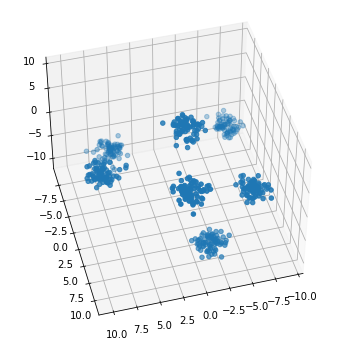

In [4]:
features, true_labels = make_blobs(n_samples=500,n_features=10,centers=7,cluster_std=0.8,random_state=random)
fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(features[:,0],features[:,1])
ax.scatter(features[:,0],features[:,1],features[:,2])
ax.view_init(45, 75)
plt.show()

In [5]:
Km=KMean(features)

In [6]:
%%time
E = Km.elbow_method(10)

Wall time: 714 ms


In [7]:
%%time
E = Km.silhouette_method(10)

<ipython-input-2-1c83dae92513>:141: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Atemp:
<ipython-input-2-1c83dae92513>:143: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Btemp:


Wall time: 2.81 s


In [8]:
%%time
G = Km.Gap_statistic(10)

Wall time: 9.33 s


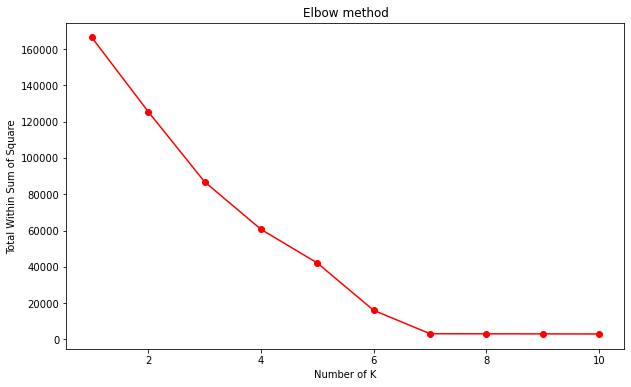

In [9]:
Km.Show_elbow_method()

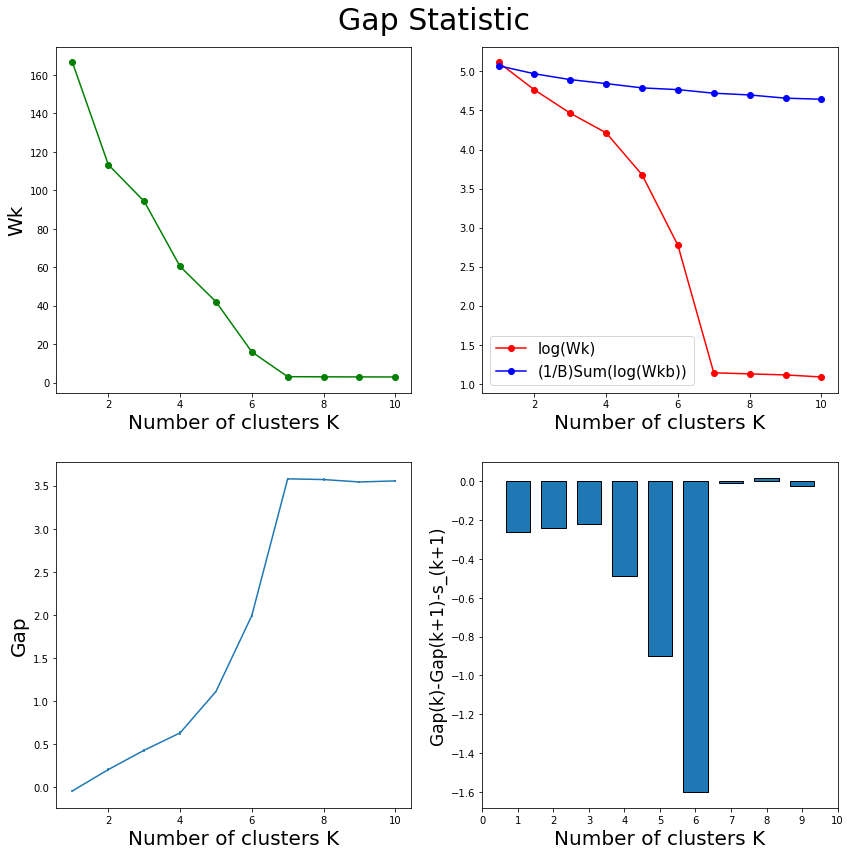

In [10]:
Km.Show_Gap_Statistic()

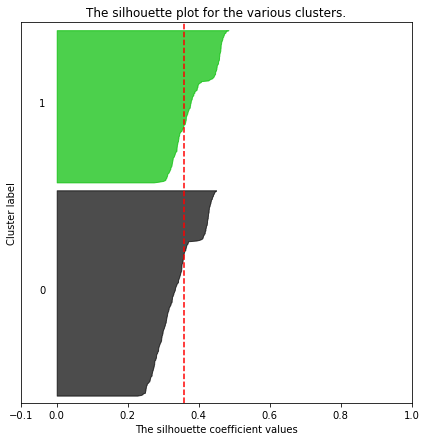

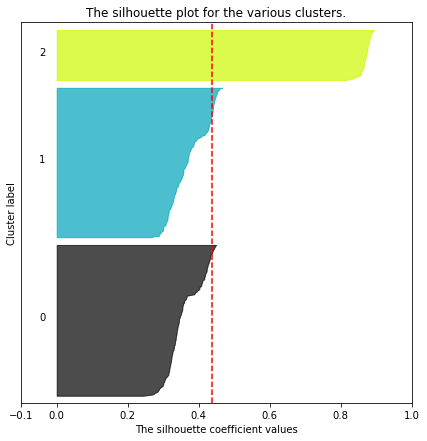

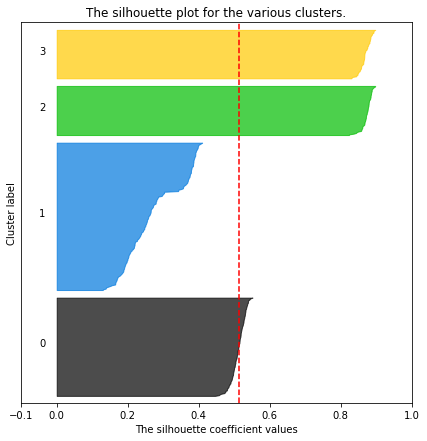

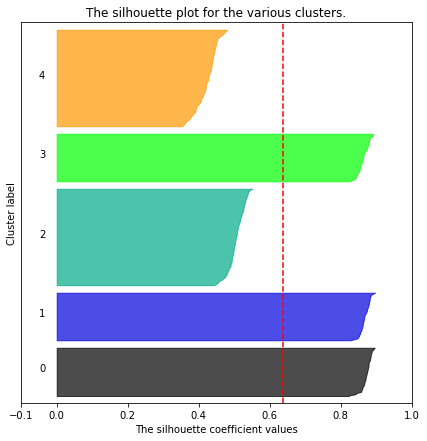

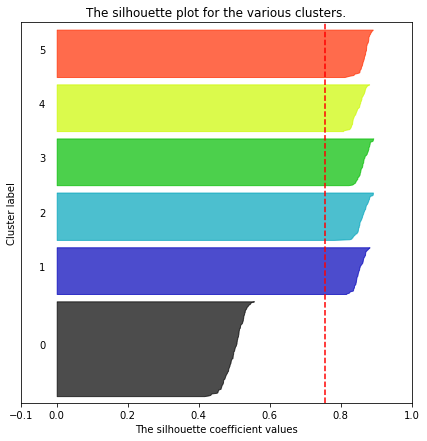

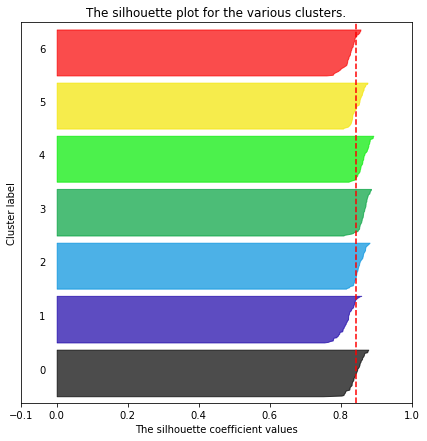

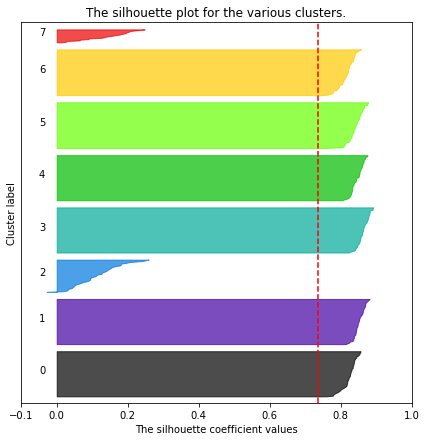

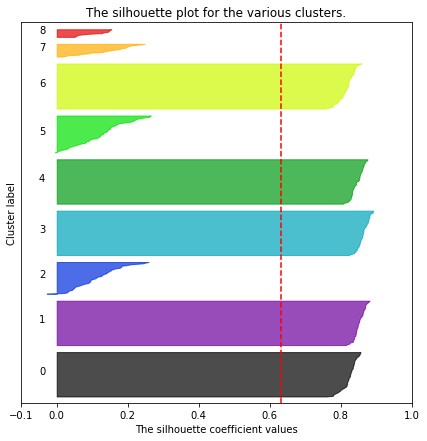

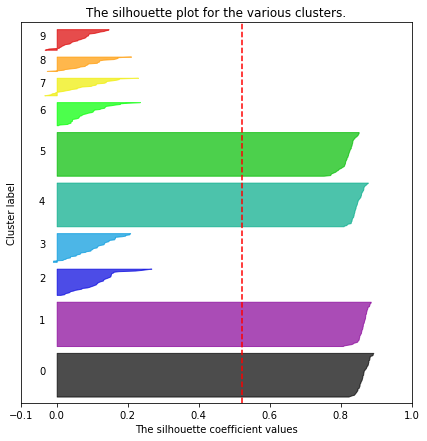

In [11]:
Km.Show_silhoutte_method()

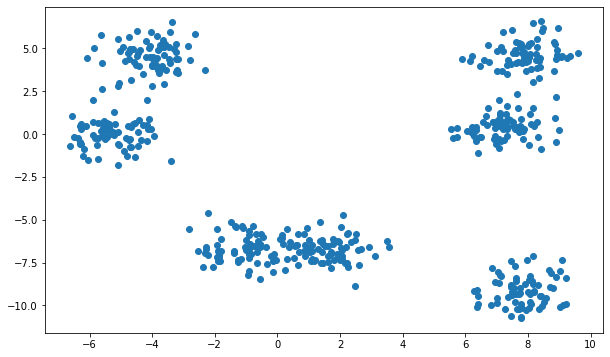

In [12]:
features, true_labels = make_blobs(n_samples=500,n_features=10,centers=7,cluster_std=0.8,random_state=random2)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.scatter(features[:,0],features[:,1])
plt.show()

In [13]:
Km=KMean(features)

In [14]:
%%time
E = Km.elbow_method(10)

Wall time: 682 ms


In [15]:
%%time
E = Km.silhouette_method(10)

<ipython-input-2-1c83dae92513>:141: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Atemp:
<ipython-input-2-1c83dae92513>:143: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if Si in Btemp:


Wall time: 2.8 s


In [16]:
%%time
G = Km.Gap_statistic(10)

Wall time: 9 s


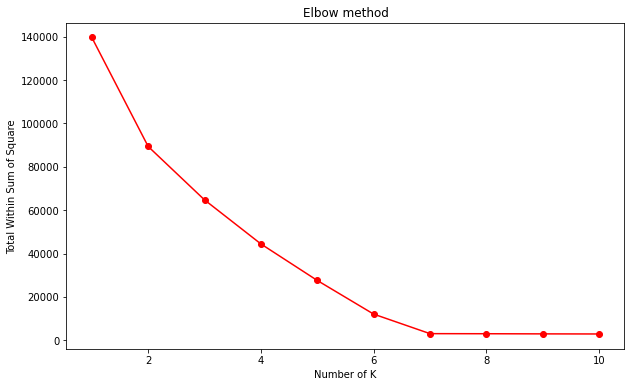

In [17]:
Km.Show_elbow_method()

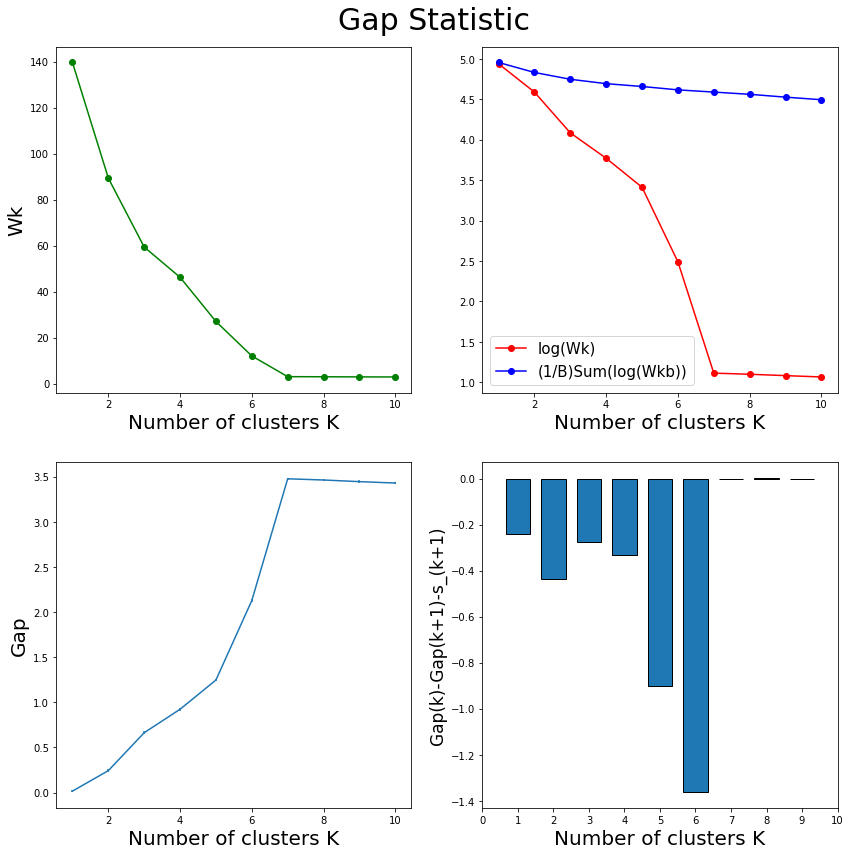

In [18]:
Km.Show_Gap_Statistic()

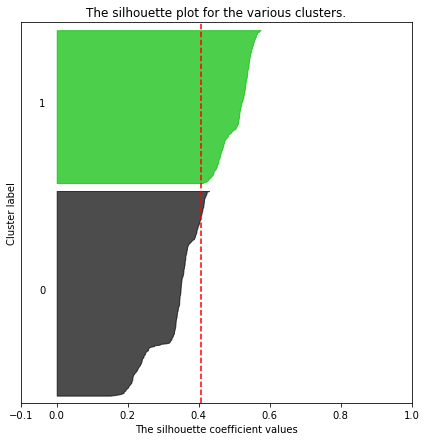

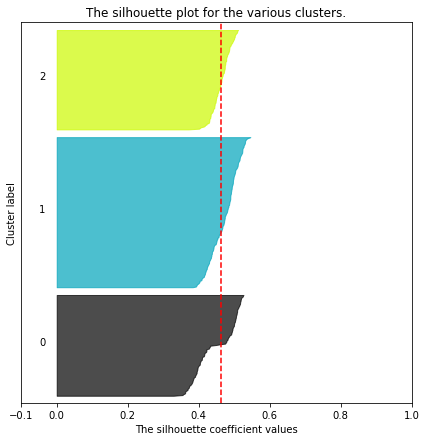

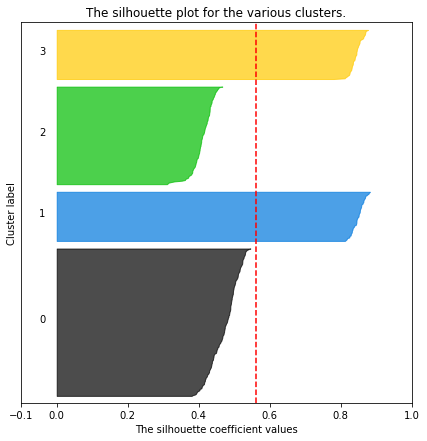

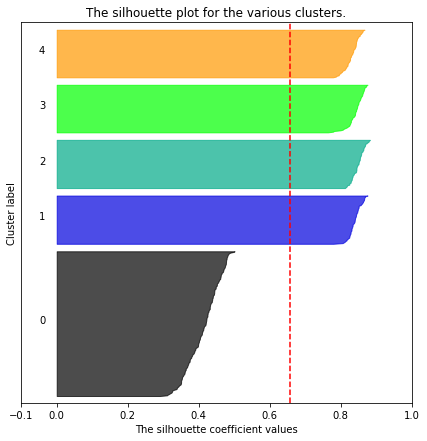

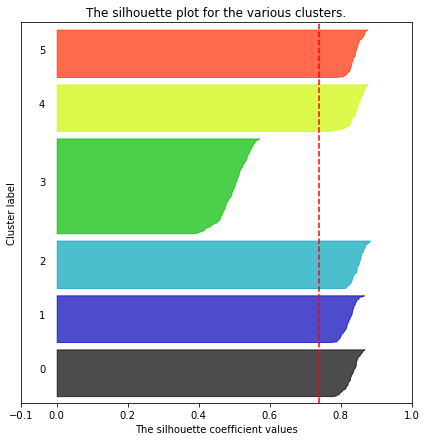

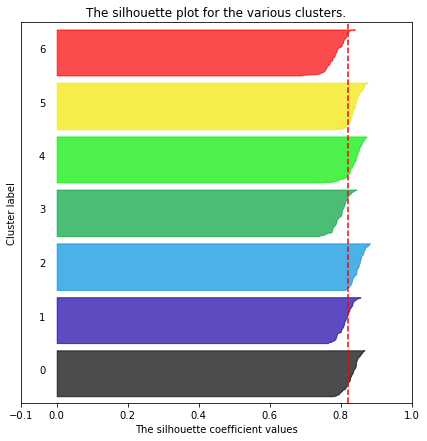

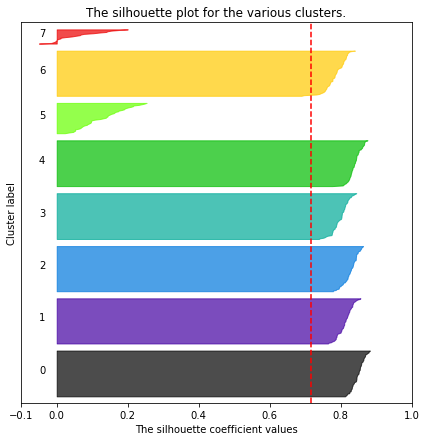

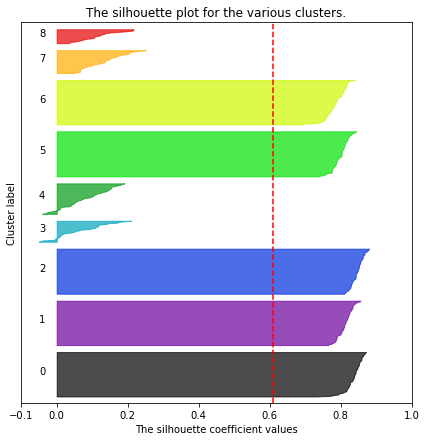

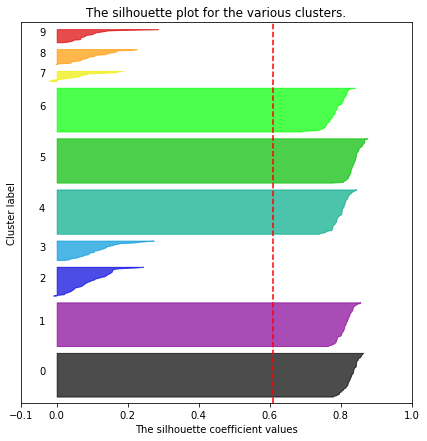

In [19]:
Km.Show_silhoutte_method()